<h1 align="center"> Metody Obliczeniowe w Nauce i Technicie </h1>
<h2 align="center"> Laboratorium 5 </h2>
<h2 align="center"> Symulowane wyżarzanie </h2>
<h3 align="center"> Problem Sudoku </h3>
<h3 align="center"> Mateusz Praski </h3>

In [2]:
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
from random import shuffle, randrange
from typing import Tuple
from math import log, exp
from simanneal import Annealer
from numba import jit
from tqdm import tqdm

In [4]:
def print_sudoku(a: np.ndarray) -> None:
    for y in range(9):
        if y > 0 and y % 3 == 0:
            print("+".join(['-'*3]*3))
        for x in range(9):
            if x > 0 and x % 3 == 0:
                print('|', end='')
            print(f'{a[x // 3, y // 3, x % 3, y % 3]}', end='')
        print('')

In [14]:
def print_unsolved(a: np.ndarray, mask: np.ndarray) -> None:
    for y in range(9):
        if y > 0 and y % 3 == 0:
            print("+".join(['-'*3]*3))
        for x in range(9):
            if x > 0 and x % 3 == 0:
                print('|', end='')
            if mask[x // 3, y // 3, x % 3, y % 3]:
                print(f'{a[x // 3, y // 3, x % 3, y % 3]}', end='')
            else:
                print('0', end='')
        print('')

In [21]:
def fill_board(board: np.ndarray, inplace=False) -> Tuple['board', 'mask']:
    board = board if inplace else board.copy()
    mask = board > 0
    for x in range(3):
        for y in range(3):
            used = set(board[x, y, ...].ravel().tolist())
            available = [x for x in range(10) if x not in used]
            shuffle(available)
            for px in range(3):
                for py in range(3):
                    if not mask[x, y, px, py]:
                        board[x, y, px, py] = available.pop()
    return board

In [204]:
class SudokuAnneal(Annealer):
    def __init__(self, sudoku):
        self.mask = sudoku > 0
        state = fill_board(sudoku)
        self.epochs = 0
        super().__init__(state)
        
    def move(self):
        self.epochs += 1
        cx, cy = np.random.randint(3, size=2)
        while self.mask[cx, cy, ...].sum() > 7:
            cx, cy = np.random.randint(3, size=2)
        pax, pay = np.random.randint(3, size=2)
        pbx, pby = np.random.randint(3, size=2)
        while self.mask[cx, cy, pax, pay] or (pax, pay) == (pbx, pby):
            pax, pay = np.random.randint(3, size=2)
        while self.mask[cx, cy, pbx, pby] or (pax, pay) == (pbx, pby):
            pbx, pby = np.random.randint(3, size=2)
        self.state[cx, cy, pax, pay], self.state[cx, cy, pbx, pby] = self.state[cx, cy, pbx, pby], self.state[cx, cy, pax, pay]
        
    def energy(self):
        penalty = 0
        for x in range(9):
            row = self.state[x // 3, :, x % 3, :].ravel().tolist()
            penalty += 9 - len(set(row))
        for y in range(9):
            col = self.state[:, y // 3, :, y % 3].ravel().tolist()
            penalty += 9 - len(set(col))
        if penalty == 0:
            self.user_exit = True
        return penalty

In [205]:
def from_file(filename) -> Tuple['board', 'mask']:
    with open(filename, 'r') as f:
        data = f.read().replace('\n', '').replace('x', '0').split(' ')[:81]
        
    data = np.array(data, dtype='int').reshape(9, 9)
    sudoku = np.empty([3]*4, dtype='int')
    for y in range(9):
        for x in range(9):
            sudoku[x // 3, y // 3, x % 3, y % 3] = data[y, x]
    return sudoku

In [240]:
def reheatable_solver(sudoku, max_trials=3, tmax=15, tmin=0.01, steps=100000, updates=1000):
    solver = SudokuAnneal(sudoku)
    for i in range(max_trials):
        solver.copy_strategy = "method"
        solver.Tmax = tmax
        solver.Tmin = tmin
        solver.steps = steps
        solver.updates = updates
        state, e = solver.anneal()
        if e == 0:
            break
    return solver

In [243]:
sudoku = from_file('sudoku/tasks/s11a.txt')

In [250]:
reheatable_solver(sudoku, tmax=10, tmin=0.02)

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     1.00%     0.00%     0:00:11     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     2.00%     0.00%     0:00:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     0.00%     0.00%     0:00:11     0:00:00

In [253]:
def get_data(directory, **anneal_kwargs):
    scores = {}
    solved = []
    t = tqdm(os.listdir(directory))
    for file in t:
        t.set_description(f'Current file: {file}')
        sudoku = from_file(os.path.join(directory, file))
        empty_cells = np.sum(sudoku == 0)
        solver = reheatable_solver(sudoku, **anneal_kwargs)
        time = solver.epochs
        solv = solver.energy() == 0
        if empty_cells not in scores:
            scores[empty_cells] = list()
        scores[empty_cells].append(time)
        solved.append(solv)
    return scores, solved

In [254]:
scores, solved = get_data('sudoku/tasks', tmax=10, tmin=0.02)

Current file: s15a.txt:   0%|          | 0/46 [00:00<?, ?it/s] Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     0.00%     0.00%     0:00:11     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     1.00%     0.00%     0:00:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
Current file: s13a.txt:   2%|▏         | 1/46 [00:31<23:41, 31.59s/it] Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     2.00%     0.00%     0:00:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
Current file: s08b.txt:   4%|▍         | 2/46 [00:46<16:08, 22.01s/it] Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          4.00     0.00%     0.00%     0:00:09     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000         

In [256]:
print('Success rate {:.2f}%'.format(100 * (np.sum(solved) / len(solved))))

Success rate 71.74%


In [257]:
times = {
    key: np.mean(val)
    for key, val in scores.items()
}

Text(0, 0.5, 'Liczba iteracji')

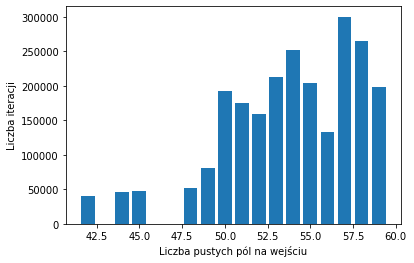

In [259]:
plt.bar(times.keys(), times.values())
plt.xlabel('Liczba pustych pól na wejściu')
plt.ylabel('Liczba iteracji')

In [267]:
# OS listdir is deterministic so we can retrieve sudokus story this way
files = os.listdir('sudoku/tasks')
data = [(status, file) for status, file in zip(solved, files)]
sorteddata = sorted(data, key=lambda item: item[1])
for status, file in sorteddata:
    print(f'Map: {file} solved: {"YES" if status else "NO"}')

Map: s01a.txt solved: YES
Map: s01b.txt solved: YES
Map: s01c.txt solved: YES
Map: s02a.txt solved: YES
Map: s02b.txt solved: YES
Map: s02c.txt solved: YES
Map: s03a.txt solved: YES
Map: s03b.txt solved: YES
Map: s03c.txt solved: YES
Map: s04a.txt solved: NO
Map: s04b.txt solved: YES
Map: s04c.txt solved: NO
Map: s05a.txt solved: YES
Map: s05b.txt solved: NO
Map: s05c.txt solved: NO
Map: s06a.txt solved: YES
Map: s06b.txt solved: YES
Map: s06c.txt solved: YES
Map: s07a.txt solved: YES
Map: s07b.txt solved: YES
Map: s07c.txt solved: YES
Map: s08a.txt solved: YES
Map: s08b.txt solved: NO
Map: s08c.txt solved: YES
Map: s09a.txt solved: NO
Map: s09b.txt solved: YES
Map: s09c.txt solved: NO
Map: s10a.txt solved: YES
Map: s10b.txt solved: YES
Map: s10c.txt solved: YES
Map: s11a.txt solved: YES
Map: s11b.txt solved: NO
Map: s11c.txt solved: YES
Map: s12a.txt solved: NO
Map: s12b.txt solved: YES
Map: s12c.txt solved: NO
Map: s13a.txt solved: YES
Map: s13b.txt solved: YES
Map: s13c.txt solved: 

In [270]:
scores, solved = get_data('sudoku/tasks', tmax=10, tmin=0.02, max_trials=10)

Current file: s15a.txt:   0%|          | 0/46 [00:00<?, ?it/s] Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     1.00%     0.00%     0:00:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     3.00%     0.00%     0:00:11     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          2.00     0.00%     0.00%     0:00:10     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
Current file: s08b.txt:   4%|▍         | 2/46 [00:41<13:18, 18.14s/it] Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000          4.00     0.00%     0.00%     0:00:09     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
Current file: s12b.txt:   9%|▊         | 4/46 [01:03<08:57, 12.79s/it] Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.02000         

In [271]:
print('Success rate {:.2f}%'.format(100 * (np.sum(solved) / len(solved))))

Success rate 82.61%


In [272]:
times = {
    key: np.mean(val)
    for key, val in scores.items()
}

Text(0, 0.5, 'Liczba iteracji')

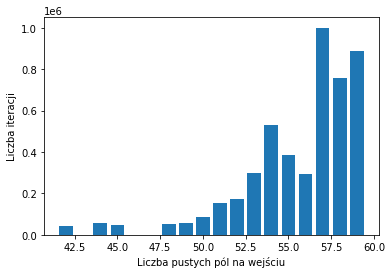

In [273]:
plt.bar(times.keys(), times.values())
plt.xlabel('Liczba pustych pól na wejściu')
plt.ylabel('Liczba iteracji')

In [274]:
files = os.listdir('sudoku/tasks')
data = [(status, file) for status, file in zip(solved, files)]
sorteddata = sorted(data, key=lambda item: item[1])
for status, file in sorteddata:
    print(f'Map: {file} solved: {"YES" if status else "NO"}')

Map: s01a.txt solved: YES
Map: s01b.txt solved: YES
Map: s01c.txt solved: YES
Map: s02a.txt solved: YES
Map: s02b.txt solved: YES
Map: s02c.txt solved: YES
Map: s03a.txt solved: YES
Map: s03b.txt solved: YES
Map: s03c.txt solved: YES
Map: s04a.txt solved: YES
Map: s04b.txt solved: NO
Map: s04c.txt solved: NO
Map: s05a.txt solved: YES
Map: s05b.txt solved: YES
Map: s05c.txt solved: YES
Map: s06a.txt solved: YES
Map: s06b.txt solved: YES
Map: s06c.txt solved: YES
Map: s07a.txt solved: YES
Map: s07b.txt solved: YES
Map: s07c.txt solved: YES
Map: s08a.txt solved: NO
Map: s08b.txt solved: YES
Map: s08c.txt solved: YES
Map: s09a.txt solved: NO
Map: s09b.txt solved: NO
Map: s09c.txt solved: YES
Map: s10a.txt solved: YES
Map: s10b.txt solved: YES
Map: s10c.txt solved: YES
Map: s11a.txt solved: YES
Map: s11b.txt solved: YES
Map: s11c.txt solved: YES
Map: s12a.txt solved: NO
Map: s12b.txt solved: YES
Map: s12c.txt solved: NO
Map: s13a.txt solved: YES
Map: s13b.txt solved: YES
Map: s13c.txt solve